# Task: `Vision-Language Model`

Given an image and a caption describing a target in that image, return a bounding box corresponding to the target’s location within the image.

Note that targets within a given image are not uniquely identified by their object class (e.g. ”airplane”, “helicopter”); multiple targets within an image may be members of the same object class. Instead, targets provided will correspond to a particular target description (e.g. “black and white drone”).

Not all possible target descriptions will be represented in the training dataset provided to participants. There will also be unseen targets and novel descriptions in the test data used in the hidden test cases of the Virtual Qualifiers, Semi-Finals / Finals. As such, Guardians will have to develop vision models capable of understanding **natural language** to identify the correct target from the scene.

For the **image datasets** provided to both Novice and Advanced Guardians, there will be no noise present. However, it is worth noting that your models will have to be adequately robust as the hidden test cases for the Virtual Qualifiers and the Semi-Finals/Finals will have increasing amounts of noise introduced. This is especially crucial for **Advanced Guardians**, due to the degradation of their robot sensors.

_Insert Code Here_

In [1]:
# !pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install -q -U torchinfo albumentations # Image Augmentation

In [8]:
import albumentations
from PIL import Image
import IPython.display as display
import torch
import requests
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import torch

import torchvision
from torchvision.transforms import functional as F
from torchvision import transforms
from torchinfo import summary
import urllib
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
cur_dir = os.getcwd()
vlm_dir = os.path.dirname(cur_dir)
til_dir = os.path.dirname(vlm_dir)
home_dir = os.path.dirname(til_dir)
test_dir = os.path.join(home_dir, 'novice')
img_dir = os.path.join(test_dir, 'images')

img_dir

'/home/jupyter/novice/images'

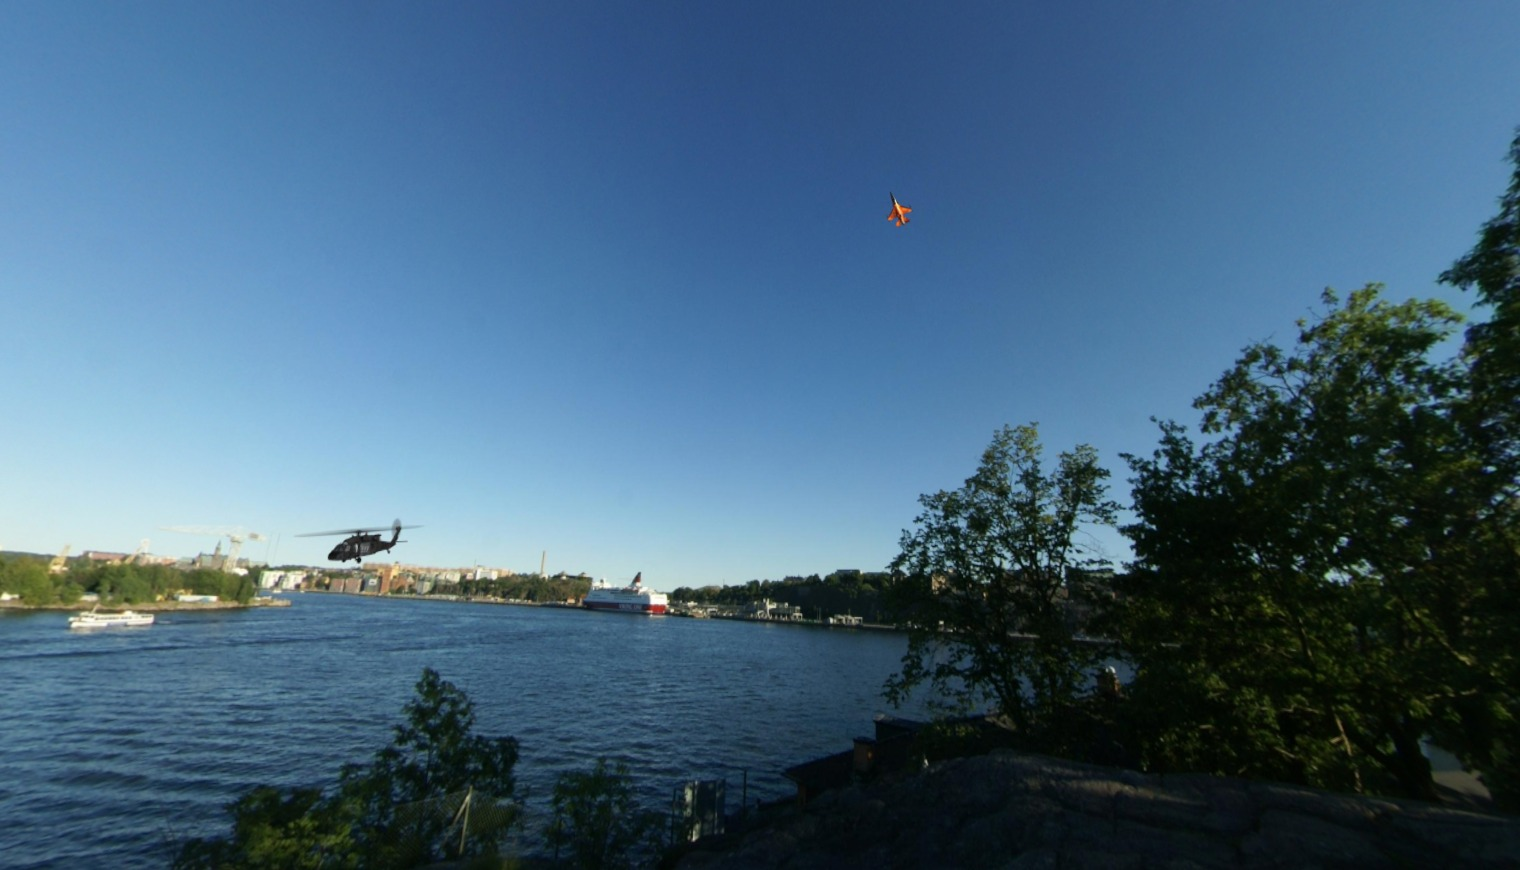

In [12]:
jpg_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

# Load the first image
if jpg_files:
    first_img_path = os.path.join(img_dir, jpg_files[10])
    first_img = Image.open(first_img_path)
    # Display the first image
    display.display(first_img)
else:
    print("No JPG files found in the directory.")

In [ ]:
# Load the pre-trained SSD300 VGG16 model
weights = torchvision.models.detection.SSD300_VGG16_Weights.DEFAULT
ssd_model = torchvision.models.detection.ssd300_vgg16(
    weights=True, box_score_thresh=0.9
)
ssd_model.eval()  # Set the model to evaluation mode
summary(ssd_model)

# Object Detection

In [6]:
import torch
from transformers import DetrForObjectDetection, DetrFeatureExtractor

# Load pre-trained DETR model and feature extractor
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
pandas                    2.2.2                    pypi_0    pypi
pandas-profiling          3.6.6                    pypi_0    pypi


In [ ]:
from PIL import Image
import requests

# Preprocess Images
# Example image loading
image = Image.open('example.jpg')

# Preprocess image
inputs = feature_extractor(images=image, return_tensors="pt")

# RUN object detection
outputs = model(**inputs)
# Get bounding boxes
target_boxes = outputs['logits'][0].softmax(-1)

# Integrate CLIP for Language-Image Matching

In [ ]:
from transformers import CLIPProcessor, CLIPModel

# Load pre-trained CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Encode the Caption
caption = "yellow helicopter"
text_inputs = clip_processor(text=[caption], return_tensors="pt")
text_features = clip_model.get_text_features(**text_inputs)

In [ ]:
# Match Caption with Detected Objects

import torch.nn.functional as F

# Extract image features for each bounding box
image_features = clip_model.get_image_features(inputs['pixel_values'])

# Compute similarity between text and image features
similarities = F.cosine_similarity(text_features, image_features)

# Find the best matching bounding box
best_match_index = similarities.argmax().item()
best_bbox = target_boxes[best_match_index]

In [ ]:
# Convert Bounding Box to LTWH Format

import numpy as np

# Convert from center_x, center_y, width, height to left, top, width, height
def convert_bbox_format(bbox):
    center_x, center_y, width, height = bbox
    left = int(center_x - width / 2)
    top = int(center_y - height / 2)
    return [left, top, int(width), int(height)]

# Get the best bounding box and convert it
best_bbox_ltwh = convert_bbox_format(best_bbox)
print(best_bbox_ltwh)